In [683]:
# coding: utf-8
#
# CS 6204 - Network Science Project - Prof. Cho
# Demetrius Davis (2019) - dldavis@vt.edu
#

import networkx as nx   
import numpy as np
import numpy.random as rd
import scipy.stats
import matplotlib.pyplot as plt
import random
import warnings

In [684]:
# If you are using Jupyter Notebook you may find following two lines useful:
warnings.filterwarnings('ignore')
% matplotlib inline

In [685]:
#
# COMMON VULNERABILITY SCORING SYSTEM (CVSS)
#
"""
    EXPLOITABILITY (E) metrics:
    - Attack Vector (AV): HP (Adjacent), LP (Network)
    - Attack Complexity (AC): HP (High), LP (Low)
    - Privileges Required (PR): HP/LP (Low)
    - User Interface (UI): HP/LP (None)

    IMPACT (I) metrics:
    - Confidentiality (C): HP/LP (Low)
    - Integrity (I): HP/LP (Low)
    - Availability (A): HP/LP (High)
"""
def get_cvss_score(is_hp_node):
    imp_score = 6.42 * (1 - ((1 - 0.22) * (1 - 0.22) * (1 - 0.56)))
    if imp_score <= 0:
        return 0
    
    exp_score = 8.22
    if is_hp_node:
        exp_score *= 0.62 * 0.44 * 0.62 * 0.85
    else:
        exp_score *= 0.85 * 0.77 * 0.62 * 0.85

    return round(min(imp_score + exp_score, 10), 1)

In [686]:
#
# GRAPH FRAMEWORK
#
class rndGeometricGraph:
    def __init__(self, isDynamic):
        self.is_dynamic_network = isDynamic
        self.compromised_nodes = []
        self.lp_index = 0
        self.gw_index = 0
        self.G = []
        self.hp_indices = []
        self.sorted_indices = []

    def isDynamic(self): return self.is_dynamic_network
    def isConnected(self): return nx.is_connected(self.G)
    def getHPNodes(self): return self.hp_indices;
    def getGraph(self): return self.G;
    def getGWNode(self): return self.gw_index;
    
    def getNumHPNodes(self):
        if self.lp_index == 0: return 0;
        return self.lp_index - 1;

    def selectGWNode(self):
        idx = 0
        for node1 in nx.nodes(self.G):
            found_hp_neighbor = False

            #print("selectGWNode(): about to set GW index: " + str(node1))
            if self.is_hp_node(node1):
                #print("selectGWNode(): --> is a HP node")
                for neighbor_node in nx.neighbors(self.G, node1):
                    if self.is_hp_node(neighbor_node):
                        found_hp_neighbor = True
                #print("selectGWNode(): HP neighbor? " + str(found_hp_neighbor))
                if not found_hp_neighbor:
                    #print("selectGWNode(): setting GW index: " + str(node1))
                    self.gw_index = node1
                    self.hp_indices.remove(node1)
                    return
    
    def isCompromisedNode(self, node_in):
        if node_in in self.compromised_nodes: return True
        return False
    
    def getCompromisedNodes(self):
        return self.compromised_nodes
    
    def addCompromisedNode(self, node_in):
        self.compromised_nodes.append(node_in)
    
    def buildGraph(self):
        # USE COORDINATES FROM RANDOM GEOMETRIC GRAPH MAKER
        xy_list = [(197.50403657219488, 143.80989059577777), (178.61842718618587, 13.334413733464313), (90.69611357508845, 185.56214063328446), (100.06330489139583, 4.189984283804504), (70.67330665700081, 185.68482250006932), (167.0314717953816, 143.50375280752087), (137.32099884588936, 72.30420517024909), (134.5252922614822, 114.37995616326573), (93.07449738524205, 94.89854914801859), (22.58124365317331, 47.4116606580848), (70.59934017286938, 95.14816167647975), (126.68108283703535, 160.45274866141398), (43.87371467807086, 142.22896617546382), (126.19958888417607, 165.79293482900326), (199.53709841831184, 138.01421920560472), (167.30142945616248, 118.0176978634184), (184.02737067375517, 4.46703076119086), (157.84006368997638, 87.80680448839344), (54.68262192202329, 101.08184944938476), (69.15179945363496, 146.2085631492383), (33.671284457562, 84.35407858161024), (44.461370659417824, 117.41525301125282), (32.583140270665226, 102.01618428819694), (43.37270119799162, 88.3699421955956), (196.82172898965467, 51.82462527420726), (131.80242865665775, 122.06258567268169), (166.53423757692767, 56.830828341202476), (81.73676373307124, 195.22790920642882), (6.709757275185058, 38.90938734847715), (6.388075261650683, 111.33311172195985), (70.21147741530439, 4.616526186203407), (73.60521722988832, 184.31268859871943), (189.6532184249488, 21.74922914723978), (186.06457555198674, 109.56473837100766), (27.02693717071607, 124.41013257703561), (173.8069184231353, 68.41351354481829), (194.8371804370941, 66.9589731127066), (122.49796099840795, 110.1663243996621), (123.59203465736005, 108.61897362157205), (32.722774932849255, 25.94925246755324), (185.3670803232078, 79.52004175158125), (36.15313991589788, 45.90867534486076), (105.57448324095475, 70.67849402799567), (72.28133965234262, 196.0859588999963), (109.95099948625486, 167.87355674969479), (9.892797331722235, 139.41597604964917), (106.04149723651726, 166.8925384834457), (35.216326306026005, 32.51747859867664), (64.00794107117534, 89.2331852005958), (164.16823420897788, 187.37768478134373), (191.3839922559565, 132.18069964630504), (131.35335549622022, 2.865253211170682), (104.11962095006825, 6.461020006351248), (13.725911163118475, 80.4887103083719), (176.12542926034206, 71.49848573202142), (105.88231292491706, 171.98448134172506), (12.019344309421554, 170.95682993005434), (125.32817614189014, 69.70307695440997), (151.05999320087747, 83.6800553471103), (65.78325819995399, 11.900721984288886), (15.152743425486314, 122.21442893956325), (1.9298569490701079, 105.63844093947914), (139.1678087870011, 106.32835598271299), (58.90188785627921, 109.2279874931805), (194.8922041868822, 130.73809366532416), (58.97290722944104, 134.11079072923818), (119.65154812557086, 89.85129603843929), (105.00577117960258, 38.768432330870525), (192.61056037573522, 62.88089671786425), (123.38192236726697, 55.3161625883005), (192.09303681486674, 193.8550978011511), (45.35762761422133, 170.13342498069684), (5.057472018097209, 170.19425521039932), (31.193518874699745, 139.0616809237419), (50.26001969326146, 60.93002077572067), (153.67211006620212, 178.79557739480305), (195.03604128802758, 45.63508452920282), (130.44020041212877, 138.73304962967018), (163.47946957866606, 189.34559345348939), (160.73962658980497, 49.08554563326171), (125.28431074809019, 26.333048916217816), (103.0071481687244, 121.25535627756237), (85.23269567986502, 88.96499330367985), (47.811314088719726, 17.71598696215888), (56.15843628897827, 109.73037947567401), (71.52083852104225, 150.54108122624086), (25.78735102299543, 48.20067993467598), (21.321298400796085, 184.61750660757556), (7.054128425587058, 17.34009516333508), (89.9895186936499, 194.21349570483378)]

        pos = {idx: (xy_list[idx][0], xy_list[idx][1]) for idx in range(len(xy_list))}
        
        #print(len(xy_list))
        #print(pos.values())

        # Build geometric graph
        self.G = nx.random_geometric_graph(len(pos), 35, pos=pos)
        
        # Check to ensure that the graph is sufficiently connected
        self.is_connected = nx.is_connected(self.G)
        print('Is the graph connected? ' + str(self.isConnected()))
        
        if self.isConnected():
            self.classifyNodes()
        
            #print("GW node index = " + str(self.gw_index))

            color_map = []
            for index in pos.keys():
                if (index == self.gw_index): # IoT GW
                    color_map.append('yellow')
                elif (index in self.hp_indices): #HP nodes
                    color_map.append('blue')
                else: # LP nodes
                    color_map.append('red')

            nx.draw(self.G, pos, node_size=100, node_color=color_map)
            #nx.draw(self.G, pos, node_size=100)
            plt.draw()
            
    def classifyNodes(self):
        # Sort nodes in decreasing degree order
        self.sorted_indices = nx.convert_node_labels_to_integers(self.G, first_label=1, ordering='decreasing degree', label_attribute=None)

        node_count = len(self.sorted_indices)
        percentage_lp_nodes = 0.2 # percentage of low-performance nodes
        self.lp_index = round(percentage_lp_nodes * node_count) + 1
        sorted_nodes = self.sorted_indices.nodes()

        # Initialize the HP indices list
        node_idx = 0
        node_val = 0
        self.hp_indices.clear()
        for node in sorted_nodes:
            if (node_idx < self.lp_index):
                node_val = node - 1
                self.hp_indices.append(node_val)
            node_idx += 1

        # Set the GW node
        self.selectGWNode()
        
    def mobilizeNetwork(self):
        # randomize location within a given range (meters) and mobilization probability
        mobilization_range = 5 # meters
        mobilization_prob = 0.3 # probability of a node moving during this time step
        
        # TBD - iterate through each node and determine if  assign a new location
        
        return

    def is_hp_node(self, node_in):
        index = 0
        for node in nx.nodes(self.G):
            if node == node_in and index in self.hp_indices:
                return True
            index += 1

        return False

    def num_hp_neighbors(self, node_in):
        if self.is_hp_node(node_in): return False
        
        cnt = 0
        for neighbor_node in nx.neighbors(self.G, node_in):
            if self.is_hp_node(neighbor_node): cnt += 1
            
        return cnt

In [687]:
#
# ATTACK GRAPH GENERATION
#
class AttackGraph:
    def __init__(self, G_in):
        self.G = G_in
        self.start_node = self.G.getGWNode()
        self.goal_nodes = self.G.getHPNodes()
        self.paths_dict = {"0": ""}
        self.vulnerability_scores = []
        self.stability_checks = []
        self.mean_degrees = []
        self.lp_nodes = []

        self.initializeLists()
        
    def getPathsDict(self): return self.paths_dict
    def getVulnerabilityScores(self): return self.vulnerability_scores
    def getStabilityChecks(self): return self.stability_checks
    def getDegreeCentrality(self): return self.mean_degrees

    def findShortestPaths(self, hop_count):
        #print(self.G.getGraph().nodes)
        
        self.paths_dict.clear()
        idx = 0
        goal_idx = 0
        self.lp_nodes.clear()
        paths = []
        chosen_path = []
        len_path = 0
        flag = False

        #print("findShortestPaths() hop_count = " + str(hop_count))
        for goal in self.goal_nodes:
            chosen_path = []
            path = nx.shortest_path(self.G.getGraph(), self.start_node, goal)
            len_path = len(path)
            if (len_path > 3):
                #print("findShortestPaths(): add path: goal = " + str(goal) + ", len_path" + str(len_path) + ", hopcnt" + str(hop_count) + ", path = " + str(path))
                if (len_path-1 <= hop_count) and path[len(path)-2] not in self.lp_nodes:
                    if len(chosen_path) > 0:
                        if len(path) < len(chosen_path): chosen_path = path
                        chosen_path = path
                        #print("PATH FOUND: " + str(len(path)))
                    else:
                        chosen_path = path
                        #print("---FIRST PATH FOUND: " + str(len(path)))
            
            if (len(chosen_path) > 0):
                #print("DONE: findShortestPaths(): add path: goal = " + str(goal) + ", lp_nodes" + str(self.lp_nodes) + ", chosen_path = " + str(chosen_path))
                self.paths_dict[str(idx)] = chosen_path
                self.lp_nodes.append(chosen_path[len(chosen_path)-2])
            idx += 1
            #print("findShortestPaths(): num paths found = " + str(len(self.paths_dict)))
        #print(self.paths_dict)
        return len(self.paths_dict)
        
    def checkNetworkStability(self, lp_node):
        H = self.G.getGraph().copy()
        H.remove_node(lp_node)
        
        return nx.is_connected(H)
            
    def initializeLists(self):
        self.vulnerability_scores = []
        self.stability_checks = []
        self.mean_degrees = []

        for node in self.G.getGraph():
            if node in self.goal_nodes: self.vulnerability_scores.append(get_cvss_score(True))
            else: self.vulnerability_scores.append(get_cvss_score(False))
            self.vulnerability_scores.append(0)

            self.stability_checks.append(self.checkNetworkStability(node))
            self.mean_degrees.append(self.G.getGraph().degree[int(node)])
            
    def evaluatePaths(self):
        path_idx = 0
        
        for path in self.paths_dict:
            lp_node = -1
            
            # Mean vulnerability (LP nodes) - calculate CVSS scores
            cvss_score_sum = 0
            degree_sum = 0
            cnt = 0
            skipped_first_node = False
            
            for node in path:
                if skipped_first_node: # skip the start node
                    # Calculate total node vulnerabilities
                    cvss_score_sum += self.vulnerability_scores[int(node)]

                    # Calculate total node degrees
                    #print("Node: " + str(node) + "---> Degree: " + str(self.G.getGraph().degree[int(node)]))
                    degree_sum += self.mean_degrees[int(node)]

                    cnt += 1
                    if cnt == (len(path)-2):
                        lp_node = int(node) # tag priority LP node
            
                skipped_first_node = True

In [696]:
# SSG PLAYER BASE CLASS
class SSGplayer():
    def __init__(self, budget):
        self.budget = budget
        self.states = []
        self.game_count = 0

    def addGoalNode(self, hp_node):
        if hp_node not in goal_nodes: goal_nodes.add(hp_node)

    def removeGoalNode(self, hp_node):
        if hp_node in goal_nodes: goal_nodes.remove(hp_node)
            
    def selectStrategy(self, G, attack_graph):
        # Iterate through each available node to find highest payoffs / lowest vulnerabilities
        #print("Hello from a SSGplayer.selectStrategy() function")
        return
    
    def defend(self, G, node):
        return

    def clearStates(self):
        for index in range(len(states)): states[index] = 0
    
# NON-DECEPTION DEFENDER CLASS - inherits from SSGplayer
class GenericDefender(SSGplayer):
    
    def scorePath(self, path, attack_graph):
        score = 0
        for idx in path:
            score = attack_graph.getVulnerabilityScores()[idx]
            if (not attack_graph.getStabilityChecks()[idx]): score *= -1
            score *= (attack_graph.getDegreeCentrality()[idx] / 2)
            idx += 1

        return score
    
    def selectStrategy(self, G, attack_graph):
        self.game_count += 1
        #print("Hello from a SSGdefender.selectStrategy() function")
    
        # Iterate through each available node to find best defensive strategy
        covered = []
        taken = []
        paths_dict = attack_graph.getPathsDict().copy()
        low_path = []
                
        for c in range(self.budget):
            low_score = 1000000
            low_idx = 0
            low_key = 0
            for path_key in paths_dict:
                if path_key in taken: continue

                score = self.scorePath(paths_dict[path_key], attack_graph)
                if score < low_score:
                    low_score = score
                    low_key = path_key
                    low_path = paths_dict[path_key]

            #print("Covering path[" + str(low_key) + "]: " + str(low_path))
            covered.append(low_path[len(low_path)-2]) # cover the priority LP node
            taken.append(low_key)

        #print("Covered[]: " + str(covered))
        c_t = []
        for idx in range(len(G.nodes)):
            if idx in covered:
                c_t.append(True)
            else:
                c_t.append(False)

        #print("Defense strategy: ")
        #print(c_t)
        return c_t # return C* as a response to the defender's move

# DECEPTION DEFENDER CLASS - inherits from SSGplayer
class DeceptionDefender(SSGplayer):
    def selectStrategy(self, G, attack_graph):
        self.game_count += 1
        #print("Hello from a DecDefender.selectStrategy() function")

        # Iterate through each available node to find best defensive strategy
        
        # Iterate through each available node to find highest payoffs / lowest vulnerabilities


# LOCATION DECEPTION DEFENDER CLASS - inherits from SSGplayer
class LocDecDefender(SSGplayer):
    def __init__(self, budget):
        self.budget = budget
        self.g_prime = []
        self.game_count = 0
    
    def scorePath(self, path, attack_graph):
        score = 0
        for idx in path:
            score = attack_graph.getVulnerabilityScores()[idx]
            if (not attack_graph.getStabilityChecks()[idx]): score *= -1
            score *= (attack_graph.getDegreeCentrality()[idx] / 2)
            idx += 1

        return score
    
    def selectStrategy(self, G, attack_graph):
        self.game_count += 1
        # Iterate through each available node to find best defensive strategy
        covered = []
        taken = []
        paths_dict = attack_graph.getPathsDict().copy()
        low_path = []
        self.g_prime = G
                
        for c in range(self.budget):
            low_score = 1000000
            low_idx = 0
            low_key = 0
            for path_key in paths_dict:
                if path_key in taken: continue

                score = self.scorePath(paths_dict[path_key], attack_graph)
                if score < low_score:
                    low_score = score
                    low_key = path_key
                    low_path = paths_dict[path_key]

            # Add decoy node
            node = len(self.g_prime.getGraph().nodes())
            self.g_prime.G.add_node(node)
            edges = G.getGraph().edges(low_path[len(low_path)-2]).copy()
            for edge in edges:
                self.g_prime.G.add_edge(node, edge[0])
                self.g_prime.G.add_edge(node, edge[1])

        c_t = []
        for idx in range(len(G.getGraph().nodes)):
            c_t.append(False)
            
        return c_t
        
    def get_g_prime(self): return self.g_prime

# GENERIC ATTACKER CLASS - inherits from SSGplayer
class GenericAttacker(SSGplayer):
    def __init__(self, budget):
        self.budget = budget
        self.attacked_nodes = []
        self.game_count = 0
        self.hit_count = 0
        self.attacker_uncertainty = 0 #whiff count
    
    def add_attacked_node(self, node_in):
        self.attacked_nodes.append(node_in)

    def scorePath(self, path, attack_graph):
        score = 0
        for idx in path:
            score = attack_graph.getVulnerabilityScores()[idx]
            idx += 1

        return score

    def noBlocks(self, path, blocked_nodes):
        for node in path:
            if node in blocked_nodes:
                return False
        return True
    
    def selectStrategy(self, G, attack_graph, blocked_nodes):
        self.game_count += 1
        score = 0
        low_score = 1000000
        low_key = 0
        low_path = []
        paths_dict = attack_graph.getPathsDict().copy()
        
        for path_key in paths_dict:
            score = self.scorePath(paths_dict[path_key], attack_graph)
            if score < low_score and self.noBlocks(paths_dict[path_key], blocked_nodes):
                low_score = score
                low_path = paths_dict[path_key]

        print("Chosen attack path: " + str(low_path))
        idx = 0
        for node in low_path:
            idx += 1
            if idx == 1: continue
            if node in G.getCompromisedNodes(): continue
            else:
                low_key = node
                if low_key not in self.attacked_nodes: self.add_attacked_node(low_key)
                break
            
        print("Attacking path[" + str(low_key) + "]: " + str(low_path))

        c_t = []
        for idx in range(len(G.getGraph().nodes)):
            if idx == low_key:
                c_t.append(True)
            else:
                c_t.append(False)

        #print("Attack strategy: ")
        #print(c_t)
        
        return c_t # return C* as a response to the defender's move

In [697]:
#
# SSG FRAMEWORK
#
class SSGDeceptionModeler:
    """
    StackelbergSecurityGame (SSG) is a bayesian normal-form stackelberg game and holds the
    following values:
    -- defender: network defender
    -- attacker: attacker/adversary
    -- c_x[l]: defender's payoff for delaying adversary
    
    -- Three  defense strategies are applied: non-deception, deception and location deception
    """
    
    def __init__(self, G_in, attack_graph_in, is_dynamic_network, dec_method_in):
        self.att_budget = 1
        self.def_budget = 35
        self.uncertainty = 0
        self.completion_status = [False, False, False]
        self.attack_graph = attack_graph_in
        self.G = G_in
        self.deception_method = dec_method_in
        self.blocked_nodes = []

        # Three defender types and one attacker
        self.ssg_defender = GenericDefender(self.def_budget)
        #self.dec_defender = DeceptionDefender(self.def_budget)
        self.loc_dec_defender = LocDecDefender(self.def_budget)
        self.attacker = GenericAttacker(self.att_budget)

    def getNumBlocks(self): return len(self.blocked_nodes)
    def addBlockedNode(self, node): self.blocked_nodes.append(node)
    
    def playStaticGame(self):
        def_strategy = []
        att_strategy = []
        g_prime = 0
        path_count = 0
        
        # Generate new attack graph
        for hop_count in range(3, 10):
            #print("playStaticGame(): " + str(hop_count))
            path_count = self.attack_graph.findShortestPaths(hop_count)
            if path_count >= self.def_budget: break;
        
        self.attack_graph.evaluatePaths()
        
        if True:
            if True:
                if self.deception_method == 1:
                    #1: Non-deception defender move -- cover or no-cover
                    def_strategy = self.ssg_defender.selectStrategy(self.G.getGraph(), self.attack_graph)
                    g_prime = self.G

                elif self.deception_method == 2:
                    #2: Deception defender move -- mask location, hide nodes/edges, create decoy nodes/edges
                    def_strategy = self.dec_defender.selectStrategy(self.G.getGraph(), self.attack_graph)
                    g_prime = self.dec_defender.get_g_prime()

                elif self.deception_method == 3:
                    #3: Location deception defender move -- mask location, hide nodes/edges, create decoy nodes/edges
                    def_strategy = self.loc_dec_defender.selectStrategy(self.G, self.attack_graph)
                    g_prime = self.loc_dec_defender.get_g_prime()

                # Attacker move
                att_strategy = self.attacker.selectStrategy(g_prime, self.attack_graph, self.blocked_nodes)
                
                self.computePayoffs(def_strategy, att_strategy)
                
            # End of if statement
                
        #End of for loop
        
        # Mobilize nodes for next static game (only if a dynamic network)
        if self.G.isDynamic():
            self.G.mobilizeNetwork()
        
        return 0
        
    def computePayoffs(self, def_strategy, att_strategy):
        uncovered_attack = False
        print("len(def strategy:) " + str(len(def_strategy)))
        # Evaluate payoffs for each node
        index = 0
        for att_action in att_strategy:
            # Check for whiffs
            if (index >= len(def_strategy)) and att_action:
                print("...WHIFFED ATTACK!... [" + str(index) + "]")
                self.uncertainty += 1
                index += 1
                continue
            
            def_action = def_strategy[index]
            #print("Inside computePayoffs()" + str(def_action))
            if def_action: # covered node
                index = index
                #print("Inside computePayoffs(covered)" + str(att_strategy[index]))
                
                if att_strategy[index]: # covered attack
                    print("...BLOCKED ATTACK!... [" + str(index) + "]")
                    self.addBlockedNode(index)

                #else: # cover but no attack
                    #print("...covered attack... [" + str(index) + "]")
                    
            else: # uncovered node
                #print("Inside computePayoffs(uncovered)" + str(att_strategy[index]))
                
                if att_strategy[index]: # uncovered attack
                    print("...UNCOVERED ATTACK!... [" + str(index) + "]")
                    self.G.addCompromisedNode(index)
                    if self.G.is_hp_node(index): uncovered_attack = True
                    break

                #else: # cover but no attack
                    #print("...uncovered but no attack... [" + str(index) + "]")
            
            index += 1
            
        # Track number of moves/games
        if uncovered_attack: self.completion_status[self.deception_method - 1] = True

    def reachedEquilibrium(self, dec_method):
        if self.deception_method == 1: return self.completion_status[0] 
        if self.deception_method == 2: return self.completion_status[1] 
        if self.deception_method == 3: return self.completion_status[2]
        return False

    def getUncertainty(self): return self.uncertainty
    def getCompromisedNodeCount(self): return len(self.G.getCompromisedNodes())


Is the graph connected? True


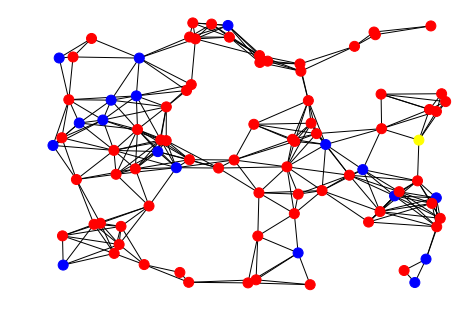

In [698]:
#
# SECTION 1 - BUILD NETWORK / BUILD ATTACK GRAPH / INITIATE SSG PLAY
#
is_dynamic_network = False
use_location_deception = True
deception_method = 3 # 1 - no deception, 2 - deception (hide edges), 3 - location deception (decoy nodes)

# Build random geometric graph
G = rndGeometricGraph(is_dynamic_network)
G.buildGraph()

# Build attack graph
attackGraph = AttackGraph(G)

ssg = SSGDeceptionModeler(G, attackGraph, is_dynamic_network, deception_method)

In [699]:
# Game result: 1 - not all results in yet (keep playing); 0 - Defender wins
game_count = 0
while (not ssg.reachedEquilibrium(deception_method)) and (game_count < len(G.getGraph().nodes)):
    ssg.playStaticGame()
    print("Completed a static SSG. Result = " + str(game_result))
    game_count += 1
    
print ("---> Equilibrium achieved. DONE.")

print("UNCERTAINTY = " + str(ssg.getUncertainty()))
print("GAME COUNT = " + str(game_count))
print("# of BLOCKS = " + str(ssg.getNumBlocks()))
print("# of COMP NODES = " + str(ssg.getCompromisedNodeCount()))
print("ASP = " + str(ssg.getCompromisedNodeCount() / game_count))

AttributeError: 'EdgeDataView' object has no attribute 'copy'

In [681]:
#
# CHART RESULTS
#
